
Circuit Simulation Example with OBI-One
======================================

This notebook demonstrates how to run circuit simulations using the obi-one simulation framework
with [BlueCelluLab](https://github.com/openbraininstitute/BlueCelluLab) as the simulator.

In [1]:
import requests
import obi_one as obi
virtual_lab_id=obi.LAB_ID_STAGING_TEST
project_id=obi.PROJECT_ID_STAGING_TEST
from entitysdk import Client, ProjectContext

from obi_auth import get_token
from obi_notebook import get_projects

obi_one_api_url = "http://127.0.0.1:8100"

token = get_token(environment="staging")
project_context = ProjectContext(virtual_lab_id=obi.LAB_ID_STAGING_TEST, project_id=obi.PROJECT_ID_STAGING_TEST)
db_client = Client(api_url="https://staging.openbraininstitute.org/api/entitycore", project_context=project_context, token_manager=token)

Now, let's generate the Simulation Config

In [ ]:
from pathlib import Path
import obi_one as obi

# === Parameters ===
sim_duration = 3000.0

# === 1. Build Form (CircuitSimulationScanConfig) ===
sim_form = obi.CircuitSimulationScanConfig.empty_config()

# Info
info = obi.Info(
    campaign_name="Small Microcircuit Simulation",
    campaign_description="Simulation of circuit with predefined neuron set and constant current stimulus"
)
sim_form.set(info, name="info")

# Neuron Sets
sim_nset = obi.AllNeurons()
sim_form.add(sim_nset, name="All Biophys")

# Timestamps
timestamps = obi.RegularTimestamps(start_time=0.0, number_of_repetitions=1, interval=100)
sim_form.add(timestamps, name="Timestamps")

# Define a CompartmentSet
comp_set = obi.CompartmentSet(
    population="biophysical",
    compartment_entries=[
        (0, 1, 0.1),
        (0, 2, 0.3),
    ],
)
sim_form.add(comp_set, name="CurrentClampTargets")

# Stimulus
stimulus = obi.PoissonSpikeStimulus(
    duration=800.0,
    timestamps=timestamps.ref,
    frequency=20,
    source_neuron_set=sim_nset.ref,
    targeted_neuron_set=sim_nset.ref
)
sim_form.add(stimulus, name="PoissonInput")

stimulus = obi.ConstantCurrentClampSomaticStimulus(
    timestamps=timestamps.ref, duration=2000.0, compartment_set=comp_set.ref, amplitude=0.5
)
sim_form.add(stimulus, name="CurrentClampInput")

# Recording
recording = obi.SomaVoltageRecording(neuron_set=sim_nset.ref)
sim_form.add(recording, name="SomaVoltage")

# Initialization block
init = obi.CircuitSimulationScanConfig.Initialize(
    circuit=obi.CircuitFromID(id_str="13a54362-0c99-43fd-94e4-58bdb5b79466"),
    node_set=sim_nset.ref,
    simulation_length=sim_duration,
)
sim_form.set(init, name="initialize")
# Validated Config
validated_sim_conf = sim_form.validated_config()

print(validated_sim_conf)

# === 2. Wrap into a Simulation ===
grid_scan = obi.GridScanGenerationTask(form=validated_sim_conf, coordinate_directory_option="ZERO_INDEX", output_root='./obi-output/run_circuit_simulations/grid_scan')
grid_scan.execute(db_client=db_client)
obi.run_tasks_for_generated_scan(grid_scan, db_client=db_client)

In [3]:
# population_name = circuit.default_population_name
simulation_config_path = grid_scan.single_configs[0].coordinate_output_root / "simulation_config.json"
print(simulation_config_path)

circuit_folder = grid_scan.single_configs[0].coordinate_output_root / "sonata_circuit"

obi-output/run_circuit_simulations/grid_scan/0/simulation_config.json


Get the path to the mod files and compile the mod files. 

In [ ]:
# Remove the old compiled mod files folder
! rm -r arm64/
# flag DISABLE_REPORTINGLIB to skip SonataReportHelper.mod and SonataReport.mod from compilation.
!../../.venv/bin/nrnivmodl -incflags "-DDISABLE_REPORTINGLIB" {circuit_folder}/mod

Run circuit simulation using BlueCelluLab backend. In future, we will support Neurodamus backend as well. This will run a SONATA simulation.  

In [ ]:
# Run the simulation
from obi_one.scientific.library.simulation_execution import run
run(
    simulation_config=simulation_config_path,
    simulator="bluecellulab", # Optional: bluecellulab or neurodamus. Default: bluecellulab
    save_nwb=False            # Optional: Save results in NWB format. Default: False
)

The results are stored in the `output` directory. The logs are also stored in the `logs` in notebooks folder.

### Spike Report Analysis using BluePySnap

We will use the example [notebook](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/06_spike_reports.ipynb) from BluePySnap to analyse the spike report generated by the circuit simulation.

In [6]:
import bluepysnap

snap_simulation = bluepysnap.Simulation(simulation_config_path)
spikes = snap_simulation.spikes
print(
    spikes.time_start,
    spikes.time_stop,
    spikes.dt
)
print(spikes.population_names)

0 3000.0 0.025
['S1nonbarrel_neurons']


In [7]:
spike_pop = spikes[spikes.population_names[0]]
node_population = spike_pop.nodes

In [8]:
filtered = spikes.filter(group={'layer':'5'}, t_start=spikes.time_start, t_stop=spikes.time_stop)
filtered.report.head()

/Users/ilkankilic/Workspace/obi-one/.venv/lib/python3.12/site-packages/bluepysnap/simulation.py:55: RuntimeWarning: Simulation node sets overwrite 147 node set(s) in Circuit node sets: L23_CHC, nbS1-HEX2-L1, L23_LBC, cSTUT, Layer23Inhibitory, dNAC, L23_NBC, hex0, L2_IPC, L1_NGC-SA, ...
  warnings.warn(


,ids,population
times,,
1.000000e-10,2,S1nonbarrel_neurons
1.000000e-10,3,S1nonbarrel_neurons
1.000000e-10,4,S1nonbarrel_neurons
1.000000e-10,5,S1nonbarrel_neurons
1.000000e-10,6,S1nonbarrel_neurons


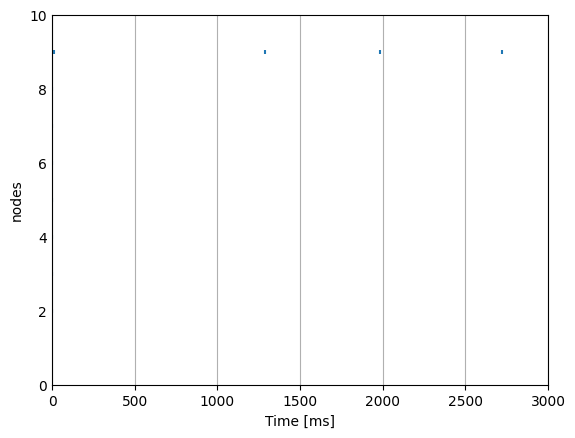

In [9]:
filtered.raster();

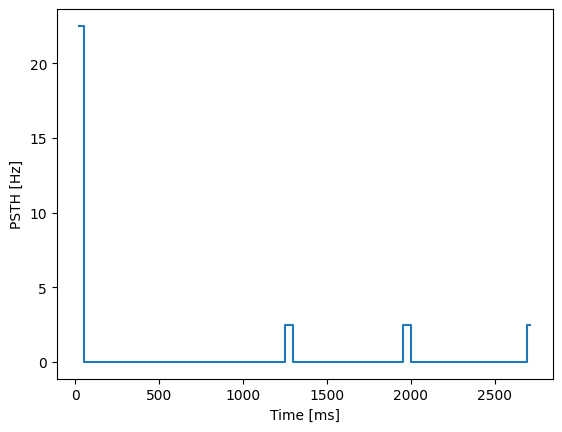

In [10]:
filtered.firing_rate_histogram();

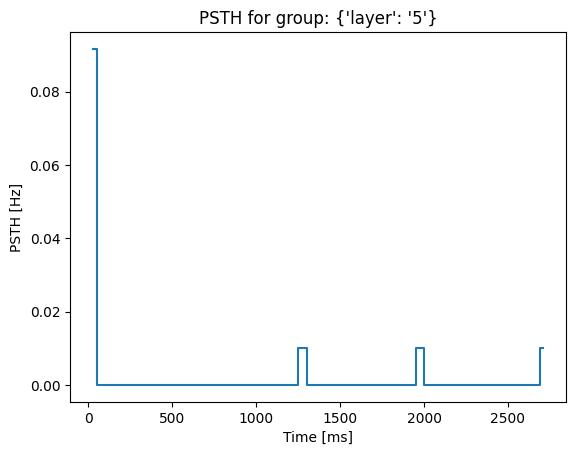

In [11]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("PSTH [Hz]")
ax.set_title(f"PSTH for group: {filtered.group}")

times = filtered.report.index

time_start = np.min(times)
time_stop = np.max(times)

# heuristic for a nice bin size (~100 spikes per bin on average)
time_binsize = min(50.0, (time_stop - time_start) / ((len(times) / 100.0) + 1.0))

bins = np.append(np.arange(time_start, time_stop, time_binsize), time_stop)
hist, bin_edges = np.histogram(times, bins=bins)
node_count = len(snap_simulation.circuit.nodes.ids(filtered.group))  # Get length of node ids for whole `group`
freq = 1.0 * hist / node_count / (0.001 * time_binsize)

# use the middle of the bins instead of the start of the bin
ax.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), freq, label="PSTH", drawstyle="steps-mid");

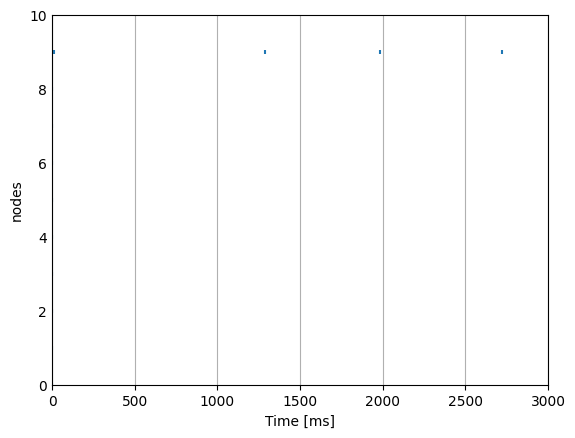

In [12]:
spikes.filter().raster();

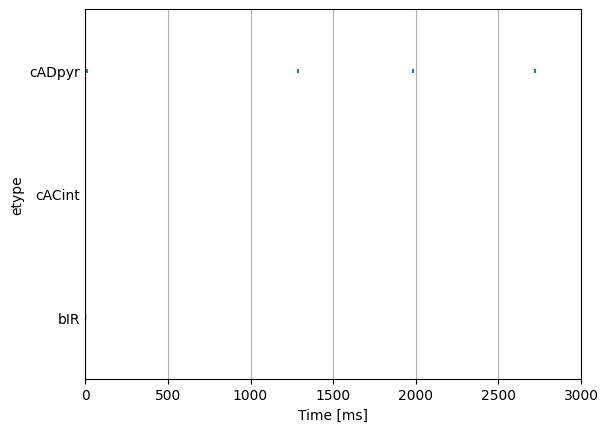

In [13]:
spikes.filter().raster(y_axis='etype');

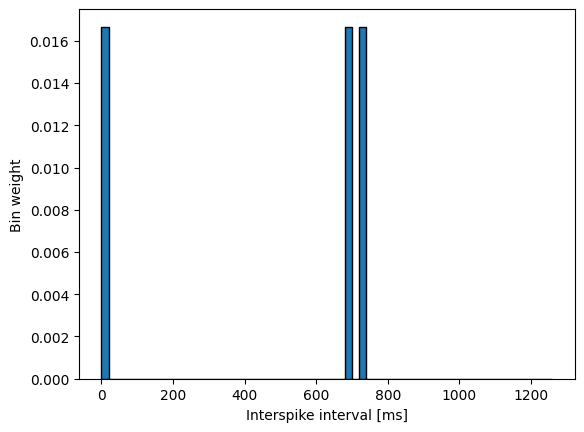

In [14]:
spikes.filter().isi(binsize=20);

### Soma Report Analysis

Let's [load](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/07_frame_reports.ipynb) the soma report using BluePySnap and plot it.

In [15]:
snap_simulation.reports

{'SomaVoltage': <bluepysnap.frame_report.SomaReport at 0x17f8a4770>}

In [16]:
soma_report = snap_simulation.reports['SomaVoltage']

In [17]:
print(
    soma_report.time_start,
    soma_report.time_stop,
    soma_report.dt
)  # Gives a warning in case the dt differs from simulation.dt

[2025-12-05 16:53:18,428] WARNING: dt from the report differs from the global simulation dt.
0.0 3000.0 0.1


In [18]:
soma_report.population_names

['S1nonbarrel_neurons']

In [19]:
soma_pop = soma_report[soma_report.population_names[0]]

In [20]:
node_population = soma_pop.nodes

In [21]:
ids = soma_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

,layer,synapse_class,x,y,z
node_ids,,,,,
0,6,EXC,3592.676277,-1025.078101,-2898.148159
1,6,EXC,3240.442277,-1083.874339,-2806.722491
2,5,EXC,4045.745764,-1113.225923,-2858.459367
3,5,EXC,4027.322429,-1176.343081,-2626.135701
4,5,EXC,3945.341039,-1121.084667,-2698.519232


In [22]:
filtered = soma_report.filter(group={'layer':'5'}, t_start= soma_report.time_start, t_stop= soma_report.time_stop)
filtered.report.head()

S1nonbarrel_neurons                                              \
                      2          3          4          5          6   
0.0            0.025000   0.025000   0.025000   0.025000   0.025000   
0.1          -58.368927 -49.616508 -45.202534 -48.229477 -51.903126   
0.2          -69.453331 -57.508907 -54.465862 -57.872799 -61.625580   
0.3          -73.927742 -60.866753 -59.874855 -62.768047 -65.675262   
0.4          -76.033325 -62.512165 -63.309742 -65.589172 -67.696358   

                                      
             7          8          9  
0.0   0.025000   0.025000   0.025000  
0.1 -51.123581 -67.321655 -53.013496  
0.2 -60.940220 -76.650757 -66.411728  
0.3 -65.081276 -80.166534 -71.955338  
0.4 -67.052490 -81.918739 -74.619705